In [1]:
from PIL import Image, ImageFont
import string
import numpy as np
from tqdm import tqdm
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision.transforms.functional import to_pil_image
from IPython.display import display
import wandb
import os
from utils.ex_clip import ExCLIP
from dotenv import load_dotenv

load_dotenv()

from utils.transform_image import (
    draw_text_with_new_lines,
    char_size,
    transform_for_resize,
)
from utils.initialize_font_data import (
    fox_text_four_lines,
    train_json_path,
    font_dir,
    all_gray_scale_image_file_dir,
    exclusive_attributes,
)
from utils.init_model import (
    preprocess,
    load_model,
    device,
    my_preprocess,
)
from utils.clip_vae import VAE, VAELoss, Discriminator, AE, AELoss
from utils.dataset import MyDataset, set_image_tensors
from utils.ex_clip import ExCLIP
from utils.lora_clip import LoRAConfig


exclusive_attributes:  ['capitals', 'monospace']
loading JIT archive /home/yuki/.cache/clip/ViT-B-32.pt


In [2]:
vae_target_characters = string.ascii_uppercase + string.ascii_lowercase
vae_target_characters_size = 64
dataset = MyDataset(
    font_dir,
    train_json_path,
    texts_for_font_image=[fox_text_four_lines],
    use_negative=True,
    use_weight=False,
    use_score=False,
    use_multiple_attributes=True,
    use_random_attributes=True,
    random_prompts_num=100,
    max_sample_num=3,
    rich_prompt=False,
    sample_num_each_epoch=30,
    image_file_dir=all_gray_scale_image_file_dir,
    attribute_threshold=50,
    attribute_under_threshold=50,
    preprocess=preprocess,
    dump_image=True,
    exclusive_attributes=exclusive_attributes,
    geta=0.2,
    single_character=False,
    use_negative_loss=True,
    use_contrastive_image_loss=False,
    use_vae_loss=True,
    vae_target_characters=vae_target_characters,
    vae_target_characters_size=vae_target_characters_size,
    store_unnormalized_image=False,
    n_px_of_unnormalized_image=64,
    use_clip_like_format=False,
    char_size=250,
    context_length=77,
)
set_image_tensors(
    dataset,
    preprocess=my_preprocess,
    sample_num=2,
)

100%|██████████| 120/120 [00:01<00:00, 104.41it/s]


load image tensors from image files ...


100%|██████████| 120/120 [00:02<00:00, 53.95it/s]


In [3]:
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
print("data_loader", len(data_loader))

data_loader 57


In [12]:
generator = VAE(
  clip_model=None,
  output_ch=1,
  cnn_based=True,
  mode_dual=False,
  use_embedding=False,
  l_relu=True,
  content_conditioned=False,
).to(device)

In [13]:
for batch in iter(data_loader):
    (
        images,
        texts,
        font_indices,
        attribute_indices,
        vae_target_images,
        one_hot_vectors,
    ) = batch
    vae_target_images = vae_target_images.to(device)
    print(vae_target_images.shape)
    break

torch.Size([64, 1, 64, 64])


torch.Size([64, 4096])


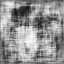

In [17]:
x, mean, var = generator(vae_target_images)
print(x.shape)
display(to_pil_image(x[0].view(64, 64).cpu()))